### **Búsqueda y Minería de Información 2021-22**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Grado en Ingeniería Informática, 4º curso
# **Sistemas de recomendación y análisis de redes sociales**

Fechas:

* Comienzo: lunes 28 / martes 29 de marzo
* Entrega: lunes 9 de mayo, 23:59

# Introducción

## Objetivos

Esta práctica reúne dos objetivos: por una parte implementar y evaluar sistemas de recomendación, y por otra, implementar funcionalidades de análisis de redes sociales. 

Respecto al primer objetivo, se desarrollarán:

* Algoritmos de recomendación basada en filtrado colaborativo.
* Métricas de evaluación de sistemas de recomendación.

Y para el segundo, se implementarán:

* Métricas que se utilizan en el análisis de redes sociales.
* Otras funcionalidades a elección opcional del estudiante, tales como más métricas, la detección de comunidades, la generación aleatoria de redes sociales, o la recomendación de contactos.

## Material proporcionado

Se proporcionan (tanto en el curso de Moodle como con enlaces dentro de este documento) software y datos para la realización de la práctica, que se divide en dos bloques:

**Bloque I – Sistemas de recomendación**

* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. De modo similar a las prácticas anteriores, se proporciona una función principal **main_recsys** que deberá funcionar con el código a implementar por el estudiante.
* Dos conjuntos de datos que incluyen ratings asignados por usuarios a películas: un conjunto pequeño de datos ficticios, y otro conjunto de datos reales disponibles en la Web de MovieLens.
  - Conjunto pequeño de prueba <ins>toy-ratings.dat</ins> con datos ficticios de ratings, así como un split manual fijo de estos datos en <ins>toy-train.dat</ins> y <ins>toy-test.dat</ins>.
  - Conjunto de datos real en la Web de [MovieLens](https://grouplens.org/datasets/movielens/latest), disponible en *ml-latest-small.zip*. De los archivos disponibles, se utilizará sólamente <ins>ratings.csv</ins>.
* Un documento de texto <ins>recsys-output.txt</ins> con la correspondiente salida estándar que deberá producir la ejecución de la función **main_recsys**.

**Bloque II – Análisis de redes sociales**

* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. De modo similar a las prácticas anteriores, se proporciona una función principal **main_sna** que deberá funcionar con el código a implementar por el estudiante.
* Redes sociales de prueba:
  - Tres redes pequeñas de prueba.
  - Redes reales: la red disponible en [SNAP (facebook_combined)](https://snap.stanford.edu/data/egonets-Facebook.html), y <ins>twitter.csv</ins> obtenida mediante una descarga de Twitter (unos 10 mil usuarios con medio millón de relaciones follow).
  - Al conjunto de redes de prueba, el estudiante añadirá dos redes más, simuladas, en el ejercicio 5.
* Un documento de texto <ins>sna-output.txt</ins> con la correspondiente salida estándar que deberá producir la ejecución de la función **main_sna**.

## Calificación

Esta práctica se calificará con una puntuación de 0 a 10 atendiendo a las puntuaciones individuales de ejercicios y apartados dadas en el enunciado. El peso de la nota de esta práctica en la calificación final de prácticas es del **40%**.

La calificación se basará en el **número** de ejercicios realizados y la **calidad** de los mismos. La puntuación que se indica en cada apartado es orientativa, en principio se aplicará tal cual se refleja pero podrá matizarse por criterios de buen sentido si se da el caso.

Para dar por válida la realización de un ejercicio, el código deberá funcionar (a la primera) integrado con las clases que se facilitan. El profesor comprobará este aspecto combinando las clases entregadas por el estudiante en los programas main facilitados, así como en otros adicionales.

La corrección de las implementaciones se observará por la **coherencia de los resultados** (por ejemplo, las métricas sobre los algoritmos de recomendación), y se valorará la eficiencia en tiempo de ejecución.

## Entrega

La entrega consistirá en un único fichero tipo *notebook* donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

## Indicaciones

La realización de los ejercicios conducirá en muchos casos a la implementación de funciones y/o clases adicionales a las que se indican en el enunciado. Algunas vendrán dadas por su aparición en las propias funciones main, y otras por conveniencia a criterio del estudiante.

Igual que en prácticas anteriores, no deberán editarse las funciones **main_recsys** y **main_sna**. Estos programas deberán ejecutar sin errores "a la primera" con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado). 


# Bloque I - Recomendación

Los esqueletos que se proporcionan a continuación son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la función **main_recsys** funcione correctamente **sin cambios**.

Se implementarán estructuras y diferentes algoritmos para el desarrollo de sistemas de recomendación. 

**Importante**: recordar que no deben recomendarse los ítems que los usuarios ya hayan puntuado.

In [17]:
"""
 Copyright (C) 2022 Pablo Castells, Alejandro Bellogín y Andrés Mena

 Este código se ha implementado para la realización de las prácticas de
 la asignatura "Búsqueda y minería de información" de 4º del Grado en
 Ingeniería Informática, impartido en la Escuela Politécnica Superior de
 la Universidad Autónoma de Madrid. El fin del mismo, así como su uso,
 se ciñe a las actividades docentes de dicha asignatura.
"""

import random
import heapq
from abc import ABC, abstractmethod

class Ranking:
    class ScoredItem:
        """
        Clase utilizada para gestionar las comparaciones que se realizan dentro del heap
        """
        def __init__(self, element):
            self.element = element

        def __lt__(self, other):
            """
            En primer lugar se compara el score. En caso de que sean iguales (mismo score),
            se compara usando el itemid (se colocará más arriba el elemento con un itemid menor).
            """
            return self.element[0] < other.element[0] if self.element[0] != other.element[0] \
                else self.element[1] > other.element[1]

        def __eq__(self, other):
            return self.element == other.element

        def __str__(self):
            return str(self.element)

        def __repr__(self):
            return self.__str__()

    def __init__(self, topn):
        self.heap = []
        self.topn = topn
        self.changed = 0

    def add(self, item, score):
        scored_item = self.ScoredItem((score, item))
        if len(self.heap) < self.topn:
            heapq.heappush(self.heap, scored_item)
            self.changed = 1
        elif scored_item > self.heap[0]:
            heapq.heappop(self.heap)
            heapq.heappush(self.heap, scored_item)
            self.changed = 1

    def __iter__(self):
        if self.changed:
            self.ranking = []
            h = self.heap.copy()
            while h:
                self.ranking.append(heapq.heappop(h).element[::-1])
            self.changed = 0
        return reversed(self.ranking)

    def __repr__(self):
        r = "<"
        for item, score in self:
            r = r + str(item) + ":" + str(score) + " "
        return r[0:-1] + ">"

## Ejercicio 1: Estructuras de datos y recomendación simple (1pt)

Implementar las clases necesarias para manejar **datos de entrada** (ratings) para los algoritmos de recomendación. La funcionalidad se implementará en una clase Ratings, que permitirá leer los datos de un fichero de texto, añadir ratings y acceder a ellos, así como un método que genere dos particiones aleatorias de entrenamiento y test, para evaluar y comparar la efectividad de diferentes algoritmos de recomendación. Nota: podéis asumir que los archivo de ratings no incluyen cabeceras.

La **salida** de un recomendador consistirá en un diccionario con un ránking por usuario. Se facilita una clase Ranking basada en heap, similar a la utilizada para motores de búsqueda en la práctica anterior, para almacenar los ránkings de recomendación; la diferencia es que ahora no se devuelven ránkings en respuesta a consultas, sino un ránking por usuario de forma proactiva y en bloque para todos los usuarios presentes en el conjunto de ratings dado (sin que los usuarios lo "pidan" explícitamente).

Implementar un primer **recomendador simple** por rating promedio en una clase `AverageRecommender`. El recomendador sólo recomendará ítems que tengan un mínimo de ratings, mínimo que se indicará como parámetro en el constructor (con ello se mejora el acierto de la recomendación). Se proporciona una clase `MajorityRecommender` a modo de ejemplo en el que el estudiante podrá basarse. También se proporciona `RandomRecommender`, que se utiliza en ocasiones como referencia en experimentos. 

In [18]:
import pandas as pd
import random
class Ratings:
    def __init__(self, file="", delim='\t'):
        self.file = file
        self.delimiter = delim
        self.ratings = {}
        self.list_items = []
        
        if file != "":
            # si es .dat
            if delim == '\t':
                with open(self.file, 'r') as file:
                    lines = [line.split() for line in file]
                for line in lines:
                    user = int(line[0])
                    item = int(line[1])
                    rating = float(line[2])
                    if user in self.ratings.keys():
                        self.ratings[user][item] = rating
                    else:
                        self.ratings[user] = {}
                        self.ratings[user][item] = rating
                    if item not in self.list_items:
                        self.list_items.append(item)

            # si es un csv            
            else:
                df = pd.read_csv(self.file)
                df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
                for i in range(len(df)):
                    user = df.iloc[i, 0]
                    item = df.iloc[i, 1]
                    rating = df.iloc[i, 2]
                    if user in self.ratings.keys():
                        self.ratings[user][item] = rating
                    else:
                        self.ratings[user] = {}
                        self.ratings[user][item] = rating
                    if item not in self.list_items:
                        self.list_items.append(item)
            

    def rate(self, user, item, rating):
        if user in self.ratings.keys():
            self.ratings[user][item] = rating
        else:
            self.ratings[user] = {}
            self.ratings[user][item] = rating
        if item not in self.list_items:
            self.list_items.append(item)
        

    def rating(self, user, item):
        return self.ratings[user][item]

    def random_split(self, ratio):
        # hacer split del diccionario de ratings
        # dado un porcentaje (ratio)
        # devuelve dos objetos de tipo rating (1 con los de train y otro con los de test)
        # se dividen estos ratings con los gustos (puntuaciones) de los usuarios
        
        ratings_train = Ratings()
        ratings_test = Ratings()
        for user in self.users():
            for item in self.user_items(user):
                if random.uniform(0, 1) > ratio:
                    ratings_test.rate(user, item, self.rating(user, item))
                else:
                    ratings_train.rate(user, item, self.rating(user, item))
        return ratings_train, ratings_test
         
        
    def users(self):
        return list(self.ratings.keys())
        
    def items(self):
        return self.list_items
    
    def nratings(self):
        n_ratings = 0  
        for key in self.ratings.keys():
            n_ratings += len(self.ratings[key].keys())
        return n_ratings
    
    def item_users(self, item):
        dict_aux = {}
        for user in self.ratings.keys():
            if item in self.ratings[user].keys():
                dict_aux[user] = self.ratings[user][item]
        return dict_aux
        
    def user_items(self, user):
        return self.ratings[user]

In [19]:
class Recommender(ABC):
    def __init__(self, training):
        self.training = training

    def __repr__(self):
        return type(self).__name__

    @abstractmethod
    def score(self, user, item):
        """ Core scoring function of the recommendation algorithm """

    def recommend(self, topn):
        dict_ranking = {}
        for user in self.training.users():
            ranking = Ranking(topn)
            for item in self.training.items():
                if item not in self.training.user_items(user):
                    score = self.score(user, item)
                    ranking.add(item, score)
            dict_ranking[user] = ranking
        return dict_ranking

class RandomRecommender(Recommender):
    
    def score(self, user, item):
        return random.random()


class MajorityRecommender(Recommender):
    def __init__(self, ratings, threshold=0):
        super().__init__(ratings)
        self.threshold = threshold

    def score(self, user, item):
        return sum(rating >= self.threshold for user, rating in self.training.item_users(item).items())
    
class AverageRecommender(Recommender):
    def __init__(self, training, minimo):
        super().__init__(training)
        self.min = minimo
    
    def score(self, user, item):
        ratings = [self.training.rating(user, item) for user in self.training.users()
                                                        if item in self.training.user_items(user)]
    
        if len(ratings) >= self.min:
            return sum(ratings)/len(ratings)
        else:
            return 0            

### Explicación/documentación

Para comprender de forma más sencilla la estructura de Ratings, la solemos visualizar como una matriz en la que las filas son los usuarios del sistema y las columnas serían los items que se puntúan; el valor que le da el usuario al ítem sería la puntuación y ese sería ya el valor dentro de la matriz. Sin embargo, a la hora de implementarlo, se estructura todo mucho más fácil con un diccionario.

Nuestra clase Ratings tiene un diccionario cuyas claves serán los usuarios y los valores de esas claves serán otro diccionario. Este otro diccionario contiene pares (clave, valor) en los que la clave será eñ número de ítem que púntua y el valor será la puntuación asignada. También hemos definido una lista que contendrá el número de ítems. Posteriormente rellenamos nuestra estructura de datos en el constructor de la clase según si el tipo de fichero que recibimos es un csv o un .dat e implementamos la funcionalidad de forma que concuerde con nuestra idea de la estructura 'Ratings'.

Para la implementación de los recomendadores, hemos dejado el método score como abstracto y cada tipo de recomendador implementará este método correspondiendo a su funcionalidad. El método recommend tendrá la misma mecánica para todos los recomendadores; esa mecánica trata de devolver un diccionario por cada usuario con un ranking estimado por la función de 'score' sobre los ítems que le debería de recomendar. Se han realizado dos implementaciones sencillas en las que una te recomienda en base a lo que ha puntuado la mayoría de los usuarios y otro está basado en la media.

## Ejercicio 2: Filtrado colaborativo kNN (3pt)

Implementar dos variantes de filtrado colaborativo mediante vecinos próximos orientado a usuarios:

* Implementar la clase `UserKNNRecommender` para realizar filtrado colaborativo **basado en usuario** por *similitud coseno* (sin normalizar por la suma de similitudes). Se sugiere crear los vecindarios "offline" en el constructor del recomendador. Se recomienda asimismo utilizar la clase `Ranking`, que utiliza un heap de ránking, para construir los vecindarios.
* Implementar una variante normalizada `NormUserKNNRecommender`. De forma similar a la recomendación por rating promedio, el algoritmo exigirá un mínimo de ratings de vecinos para aceptar recomendar un ítem (con ello se mejora el acierto de la recomendación).

In [20]:
import math
class UserSimilarity(ABC):
    @abstractmethod
    def sim(self, user1, user2):
        """ Computation of user-user similarity metric """

class CosineUserSimilarity(UserSimilarity):
    def __init__(self, ratings):
        self.ratings = ratings
    
    def compute_module(self, user):
        module = 0
        for item in self.ratings.user_items(user).keys():
            module += self.ratings.rating(user, item) **2
        return math.sqrt(module)
        
    def sim(self, user1, user2):
        module_user1 = self.compute_module(user1)
        module_user2 = self.compute_module(user2)
        suma_numerador = 0
        for item in self.ratings.user_items(user1).keys():
            if item in self.ratings.user_items(user2).keys():
                suma_numerador += self.ratings.rating(user1, item) * self.ratings.rating(user2, item)
                
        return suma_numerador / (module_user1 * module_user2)
        
                
class UserKNNRecommender(Recommender):
    def __init__(self, training, sim, k):
        super().__init__(training)
        self.similarity = sim
        self.k = k
        self.k_most_similar = {}
        
        # guardamos los k usuarios mas similares para cada usuario
        for user in self.training.users():
            ranking = Ranking(k)
            for user_aux in self.training.users():
                if user != user_aux:
                    similarity = self.similarity.sim(user, user_aux)
                    if similarity != 0:
                        ranking.add(user_aux, similarity)
            self.k_most_similar[user] = ranking   
    
    def score(self, user, item):
        suma = 0
        for similar_user, similarity in self.k_most_similar[user]:
            if item in self.training.ratings[similar_user].keys():
                suma += similarity * self.training.rating(similar_user, item)
        return suma
            
class NormUserKNNRecommender(UserKNNRecommender):
    def __init__(self, training, sim, k, minimo):
        super().__init__(training, sim, k)
        self.min = minimo
    
    def score(self, user, item):
        suma = 0 
        suma_similitudes = 0
        contador_ratings = 0
        for similar_user, similarity in self.k_most_similar[user]:
            if item in self.training.ratings[similar_user].keys():
                suma += similarity * self.training.rating(similar_user, item)
                suma_similitudes += similarity
                contador_ratings += 1
        if suma_similitudes == 0 or contador_ratings < self.min:
            return 0
        else:
            return suma / suma_similitudes

### Explicación/documentación

En este apartado hemos implementado la función de similitud entre usuarios y dos recomendadores de filtrado colaborativo basados en usuario. La función de similitud es aplicar el coseno a los dos usuarios.

En cada recomendador, ha sido necesario guardar los K usuarios más similares de cada uno de los usuarios del sistema, ya que está basado en el algoritmo KNN (K-Nearest Neighbours). La función de score es simplemente aplicar las fórmulas vistas en teoría y realizar el sumatorio del producto de las similitudes por su rating correspondiente. En el caso de la versión normalizada, simplemente hay que dividir entre la suma de las similitudes.


## Ejercicio 3: Ampliación de algoritmos (1pt)

Implementar dos variantes adicionales de los algoritmos de filtrado colaborativo y basados en contenido, tales como:

* Un algoritmo colaborativo por **vecinos próximos orientado a ítem**. 
* **Otras variantes** adicionales a elección del estudiante, por ejemplo: similitud de Pearson, kNN centrado en la media. 

Para probar los métodos deberá completarse la función `student_test_recsys()` del apartado siguiente que ilustre la ejecución de las variantes adicionales.

In [21]:
# Ampliación de algoritmos

### Explicación/documentación

(por hacer)

## Ejercicio 4: Evaluación (1pt)

Se desarrollarán clases que permitan calcular métricas para evaluar y comparar el acierto de los recomendadores: se implementarán **precisión** y **recall**. 

Como resumen de este bloque, se incluirá una *tabla con los valores de las métricas* (dos columnas) más el tiempo de ejecución (una columna más) sobre todos los algoritmos implementados (filas), al menos para el conjunto de datos de <ins>ml-latest-small.zip</ins>.

Opcionalmente, se podrán implementar otras métricas a elección del estudiante (nDCG, etc.), cuya prueba se incluirá en la función `student_test_recsys()`.

In [22]:
class EvaluationMetric(ABC):
    def __init__(self, test, cutoff):
        self.test = test
        self.cutoff = cutoff

    def __repr__(self):
        return type(self).__name__ + ("@" + str(self.cutoff) if self.cutoff != math.inf else "")

    # Esta función se puede dejar abstracta declarándola @abstractmethod, 
    # pero también se puede meter algo de código aquí y el resto en las
    # subclases - a criterio del estudiante.
    @abstractmethod
    def compute(self, recommendation):
        """ Completar """

class Precision(EvaluationMetric):
    def __init__(self, test, cutoff, threshold):
        super().__init__(test, cutoff)
        self.threshold = threshold
    
    def compute(self, recommendation):
        list_eval_users = []
        for user in recommendation:
            cont_user = 0
            if user not in self.test.users():
                list_eval_users.append(0)
                continue
            for item in self.test.user_items(user):
                lista_tuplas = [tupla.element[1] for tupla in recommendation[user].heap]
                if item in lista_tuplas and self.test.rating(user, item) >= self.threshold:
                    cont_user += 1
            list_eval_users.append(cont_user / self.cutoff)
        return sum(list_eval_users) / len(list_eval_users)
                        
class Recall(EvaluationMetric):
    def __init__(self, test, cutoff, threshold):
        super().__init__(test, cutoff)
        self.threshold = threshold
    
    def compute(self, recommendation):
        list_eval_users = []
        for user in recommendation:
            cont_user = 0
            denominador = 0
            if user not in self.test.users():
                list_eval_users.append(0)
                continue
            for item in self.test.user_items(user):
                lista_tuplas = [tupla.element[1] for tupla in recommendation[user].heap]
                if self.test.rating(user, item) >= self.threshold:
                    denominador += 1
                if item in lista_tuplas and self.test.rating(user, item) >= self.threshold:
                    cont_user += 1
                    
            if denominador == 0:
                list_eval_users.append(0)
            else:
                list_eval_users.append(cont_user / denominador)
        return sum(list_eval_users) / len(list_eval_users)

In [23]:
def student_test_recsys(train, test, k, topn, cutoff):
    pass

### Explicación/documentación

La funcionalidad en ambas métricas ha sido bastante parecida, lo único que cambia es en el caso del denominador en el cual en la Precisión sería el cutoff que se define previamente y en el recall únicamente los ítems puntuados que estén por encima del threshold. La parte del numerador contiene el número de usuarios que han puntuado ese ítem de la recomendación y que además la puntuación sea mayor que el threshold. Se saca una serie de puntuaciones y se acaba haciendo la media para obtener la métrica total para cada recomendador.

Ejemplo de tabla de resumen: 

|      | Precision@K | Recall@K | Tiempo |
| ----- | --------- | -------- | ----- |
| Alg1 | | | |
| Alg2 | | | |
| ... | | | |
| AlgN | | | |

## Programa de prueba **main_recsys**

Descarga los ficheros del curso de Moodle y coloca sus contenidos en una carpeta **recsys_data** en el mismo directorio que este *notebook*.

In [24]:
import datetime
import time
import itertools

def main_recsys():
    random.seed(42)
    print("=========================\nToy test")
    toy_test("recsys_data/toy", '\t')
    print("=========================\nTesting toy dataset")
    test_dataset("recsys_data/toy-ratings.dat", 1, 2, k=4, min=2, topn=4, cutoff=4)
    print("=========================\nTesting MovieLens \"latest-small\" dataset")
    test_dataset("recsys_data/ratings.csv", 35, 1240, k=10, min=3, topn=5, cutoff=5, delimiter=',')


# First tests on toy dataset, using a pre-constructed data split
def toy_test(dataset, separator='\t'):
    training = Ratings(dataset + "-train.dat", separator)
    test = Ratings(dataset + "-test.dat", separator)
    metrics = [Precision(test, cutoff=4, threshold=4), Recall(test, cutoff=4, threshold=4)]
    evaluate_recommenders(training, metrics, k=4, min=2, topn=4)


# More complete testing on a generic dataset
def test_dataset(ratings_file, user, item, k, min, topn, cutoff, delimiter='\t'):
    ratings = Ratings(ratings_file, delimiter)
    # Test Ratings class on the dataset
    test_data(ratings, user, item)
    # Run some recommenders on the entire rating data as input - no evaluation
    test_recommenders(ratings, k, min, topn)
    # Now produce a rating split to re-run the recommenders on the training data and evaluate them with the test data
    train, test = ratings.random_split(0.8)
    metrics = [Precision(test, cutoff, threshold=4), Recall(test, cutoff, threshold=4)]
    evaluate_recommenders(train, metrics, k, min, 2 * topn)  # Double top n to test a slightly deeper ranking

    # Additional testing?
    #student_test_recsys(train, test, k, topn, cutoff)


# Test the rating data handling code (Ratings class)
def test_data(ratings, user, item):
    print("-------------------------\nTesting the data structures")
    print(ratings.nratings(), "ratings by", len(ratings.users()), "users on", len(ratings.items()), "items")
    print("Ratings of user", user, ":", ratings.user_items(user))
    print("Ratings of item", item, ":", ratings.item_users(item))

# Run some recommenders on the some rating data as input - no evaluation
def test_recommenders(ratings, k, min, topn):
    print("-------------------------")
    start = time.process_time()
    test_recommender(RandomRecommender(ratings), topn)
    test_recommender(MajorityRecommender(ratings, threshold=4), topn)
    test_recommender(AverageRecommender(ratings, min), topn)
    
    timer(start)
    start = time.process_time()
    print("Creating user cosine similarity")
    sim = CosineUserSimilarity(ratings)
    timer(start)
    start = time.process_time()
    print("Creating kNN recommender")
    knn = UserKNNRecommender(ratings, sim, k)
    timer(start)
    start = time.process_time()
    test_recommender(knn, topn)
    timer(start)
    start = time.process_time()
    test_recommender(NormUserKNNRecommender(ratings, sim, k, min), topn)
    timer(start)

# Run one recommender on the some rating data as input - no evaluation
def test_recommender(recommender, topn):
    print("Testing", recommender, "(top", str(topn) + ")")
    recommendation = recommender.recommend(topn)
    for user in itertools.islice(recommendation, 4):
        print("    User", user, "->", recommendation[user])

# Create some recommenders and send them for evaluation for a list of given metrics
def evaluate_recommenders(training, metrics, k, min, topn):
    print("-------------------------")
    start = time.process_time()
    evaluate_recommender(RandomRecommender(training), topn, metrics)
    evaluate_recommender(MajorityRecommender(training, threshold=4), topn, metrics)
    evaluate_recommender(AverageRecommender(training, min), topn, metrics)
    sim = CosineUserSimilarity(training)
    knn = UserKNNRecommender(training, sim, k)
    evaluate_recommender(knn, topn, metrics)
    evaluate_recommender(NormUserKNNRecommender(training, sim, k, min), topn, metrics)

# Run one recommender and evaluate a list of metrics on its output
def evaluate_recommender(recommender, topn, metrics):
    print("Evaluating", recommender)
    recommendation = recommender.recommend(topn)
    for metric in metrics:
        print("   ", metric, "=", metric.compute(recommendation))

def timer(start):
    print("--> elapsed time:", datetime.timedelta(seconds=round(time.process_time() - start)), "<--")

main_recsys()

Toy test
-------------------------
Evaluating RandomRecommender
    Precision@4 = 0.05
    Recall@4 = 0.2
Evaluating MajorityRecommender
    Precision@4 = 0.05
    Recall@4 = 0.2
Evaluating AverageRecommender
    Precision@4 = 0.1
    Recall@4 = 0.4
Evaluating UserKNNRecommender
    Precision@4 = 0.1
    Recall@4 = 0.4
Evaluating NormUserKNNRecommender
    Precision@4 = 0.15
    Recall@4 = 0.6
Testing toy dataset
-------------------------
Testing the data structures
22 ratings by 5 users on 10 items
Ratings of user 1 : {1: 1.0, 5: 5.0, 7: 2.0, 10: 5.0}
Ratings of item 2 : {2: 2.0, 4: 2.0}
-------------------------
Testing RandomRecommender (top 4)
    User 1 -> <8:0.9731157639793706 4:0.8071282732743802 6:0.7297317866938179 2:0.6037260313668911>
    User 2 -> <8:0.8617069003107772 5:0.8294046642529949 10:0.6185197523642461 3:0.577352145256762>
    User 3 -> <7:0.7045718362149235 6:0.28938796360210717 8:0.23279088636103018 4:0.22789827565154686>
    User 4 -> <5:0.6356844442644002 9:0.3

KeyboardInterrupt: 

### Salida obtenida por el estudiante

*(por hacer)*

# Bloque II - Análisis de redes sociales

Los esqueletos que se proporcionan en este apartado son a modo de guía; el estudiante puede modificarlo todo libremente, siempre que la función **main_sna** funcione correctamente **sin cambios**.

Para simplificar, en los ejercicios que siguen supondremos que las redes son no dirigidas.

## Ejercicio 5: Preliminares (2pt)

Generar dos **redes sociales simuladas** siguiendo los modelos de Barabási-Albert y Erdös-Rényi. El tamaño y densidad de los grafos se deja a elección propia. Se puede utilizar para ello cualquier herramienta (como NetworkX ([documentación](https://networkx.org/documentation/stable/tutorial.html#graph-generators-and-graph-operations)), o el entorno interactivo de Gephi), o bien programar implementaciones propias (lo cual también es muy sencillo).

Realizar un análisis básico de la **distribución del grado** en las siete redes sociales de la práctica: small x 3, Facebook, Twitter, Barabási-Albert y Erdös-Rényi. Para cada red:

* Generar una gráfica de distribución del grado (utilizando escala log-log cuando ello sea útil) y comprobar en qué medida se observa una distribución power law.
* Verificar si se observa la paradoja de la amistad (en sus diferentes versiones).

Los resultados de este ejercicio no conllevan entrega de software, sino sólo la documentación de los mismos en el apartado de memoria.

In [8]:
# Si se ha realizado algún código, se puede incluir aquí
# Si no se ha utilizado Python, se puede utilizar el apartado de explicación para describir el proceso y las herramientas utilizadas
import networkx as nx
import matplotlib.pyplot as plt
import csv
from collections import OrderedDict

def edges(data_file, red):
    
    if data_file:
        Data = open(data_file, "r", encoding='utf8')
        
        diccionario_grados = {}
        for line in Data.readlines():
            line = line.split('\n')[0].split(',')
            if line[0] not in diccionario_grados.keys():
                diccionario_grados[line[0]] = 1
            else:
                diccionario_grados[line[0]] += 1
            
            if line[1] not in diccionario_grados.keys():
                diccionario_grados[line[1]] = 1
            else:
                diccionario_grados[line[1]] += 1
        
    else:
        G = red
    
        diccionario_grados = {}
        for pair in G.edges():
            if pair[0] not in diccionario_grados.keys():
                diccionario_grados[pair[0]] = 1
            else:
                diccionario_grados[pair[0]] += 1
                

    nodosXgrado = {}
    for nodo in diccionario_grados.keys():
        if diccionario_grados[nodo] not in nodosXgrado.keys():
            nodosXgrado[diccionario_grados[nodo]] = 1
        else:
            nodosXgrado[diccionario_grados[nodo]] += 1
            
    nodosXgrado_ordenado = OrderedDict(sorted(nodosXgrado.items()))
    grados = list(nodosXgrado_ordenado.keys())
    nNodos = list(nodosXgrado_ordenado.values())
        
    return grados, nNodos

def plot_graph(nodos, grados, nombre_red):
    plt.title("Grados Ordenados " + nombre_red)

    plt.xlabel('Grado')
    plt.ylabel('Nº nodos')
    plt.plot(grados, nodos)

    plt.show()
    
def plot_graph_log(nodos, grados, nombre_red):
    plt.title("Grados Ordenados " + nombre_red)

    plt.xlabel('Grado')
    plt.ylabel('Nº nodos')
    plt.plot(grados, nodos)
    plt.xscale("log")
    plt.yscale("log")

    plt.show()

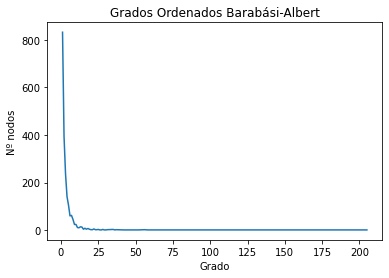

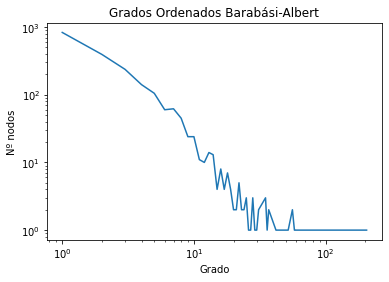

In [9]:
red_barabasi = nx.barabasi_albert_graph(n=4000, m=2)

grados, nodos = edges(data_file=None, red=red_barabasi)
plot_graph(nodos, grados, "Barabási-Albert")
plot_graph_log(nodos, grados, "Barabási-Albert")

Como se puede observar en las graficas obtenidas, esta red de tipo Barabási-Albert, cumple tanto con la distribucion power law como con la paradoja de la amistad.

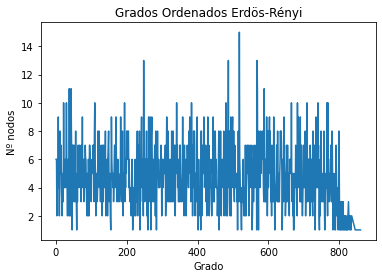

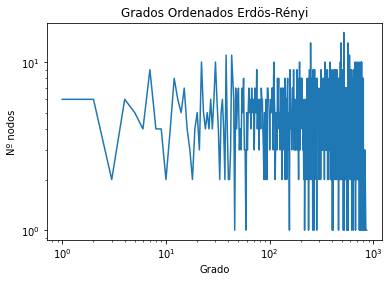

In [10]:
red_erdos = nx.erdos_renyi_graph(n=4000, p=0.2)

grados, nodos = edges(data_file=None, red=red_erdos)
plot_graph(nodos, grados, "Erdös-Rényi")
plot_graph_log(nodos, grados, "Erdös-Rényi")

Como se puede observar en las graficas obtenidas, esta red de tipo Barabási-Albert, no cumple ni con la distribucion power law ni con la paradoja de la amistad.

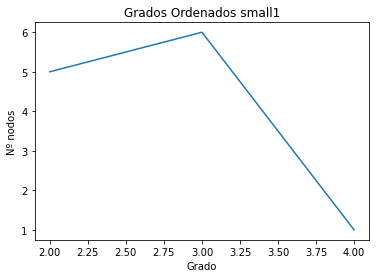

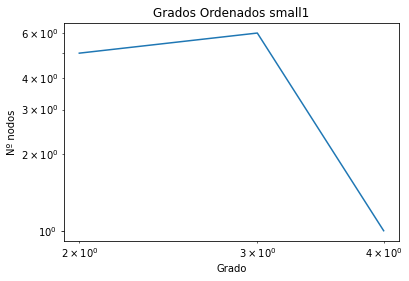

In [11]:
grados, nodos = edges(data_file="graphs/small1.csv", red=None)
plot_graph(nodos, grados, "small1")
plot_graph_log(nodos, grados, "small1")

En este caso, teniendo en cuenta que el tamaño de la red es muy pequeño, no podemos determinar si sigue una distribucion power law y si parece que sigue una distribucion parecida a la de la paradoja de la amistad, aunque no podemos saberlo con seguridad.

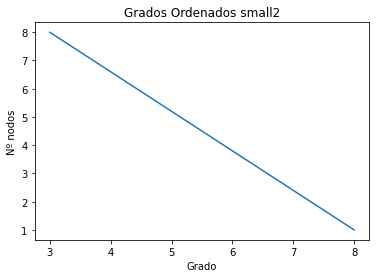

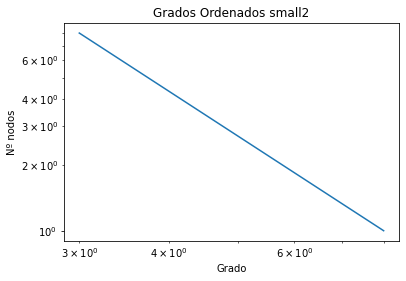

In [12]:
grados, nodos = edges(data_file="graphs/small2.csv", red=None)
plot_graph(nodos, grados, "small2")
plot_graph_log(nodos, grados, "small2")

En este caso, teniendo en cuenta que el tamaño de la red es muy pequeño, no podemos determinar si sigue una distribucion power law y si parece que sigue una distribucion parecida a la de la paradoja de la amistad, aunque no podemos saberlo con seguridad.

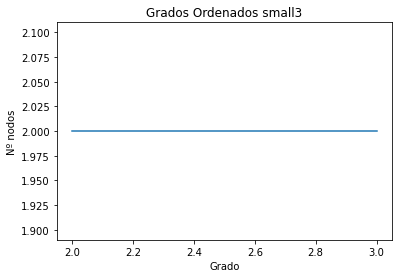

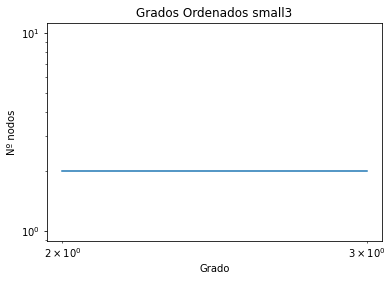

In [13]:
grados, nodos = edges(data_file="graphs/small3.csv", red=None)
plot_graph(nodos, grados, "small3")
plot_graph_log(nodos, grados, "small3")

En este caso no se cumplen niguna de las dos condiciones.

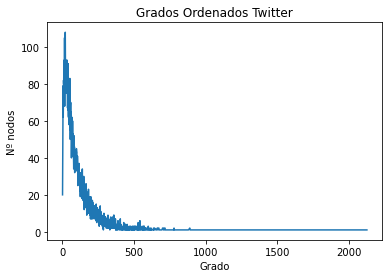

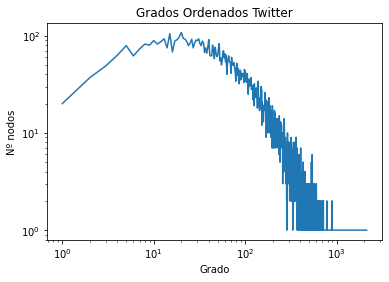

In [14]:
grados, nodos = edges(data_file="graphs/twitter.csv", red=None)
plot_graph(nodos, grados, "Twitter")
plot_graph_log(nodos, grados, "Twitter")

Como se puede observar en las graficas obtenidas, esta red basada en los datos de Twitter, cumple tanto con la distribucion power law como con la paradoja de la amistad.

In [15]:
from abc import ABC, abstractmethod

class UndirectedSocialNetwork:
    def __init__(self, file, delimiter='\t', parse=0):
        
        Data = open(file, "r", encoding='utf8')
        
        self.graph = {}
        self.nEdges = 0
        for line in Data.readlines():
            self.nEdges += 1
            line = line.split('\n')[0].split(',')
            if line[0] not in self.graph.keys():
                self.graph[line[0]] = []
                self.graph[line[0]].append(line[1])
            else:
                self.graph[line[0]].append(line[1])
            
            if line[1] not in self.graph.keys():
                self.graph[line[1]] = []
                self.graph[line[1]].append(line[0])
            else:
                self.graph[line[1]].append(line[0])                
            
    def users(self):
        return list(self.graph.keys())

    def contacts(self, user):
        return list(self.graph[str(user)])

    def degree(self, user):
        return len(list(self.graph[str(user)]))

    def add_contact(self, u, v):
        self.graph[str(u)].append(v)

    def connected(self, u, v):
        if v in self.graph[str(u)]:
            return True
        else:
            return False

    def nedges(self):
        return self.nEdges

class Metric(ABC):
    def __repr__(self):
        return type(self).__name__

    @abstractmethod
    def compute_all(self, network):
        """" Compute metric on all users or edges of network """


class LocalMetric(Metric):
    def __init__(self, topn):
        self.topn = topn

    @abstractmethod
    def compute(self, network, element):
        """" Compute metric on one user or edge of network """

class UserClusteringCoefficient(Metric): # or LocalMetric? or other useful intermediate class?
    def __init__(self, topn):
        self.topn = topn
    
    def compute(self, network, element):
        
        vecinos = network.contacts(element)
        cont = 0
        for v in vecinos:
            for u in vecinos:
                if network.connected(v, u):
                    cont += 1
        #Dividimos entre dos ya que una conexion que une dos nodos cuenta como uno
        cont /= 2
        
        return cont/(network.degree(element)*( network.degree(element) - 1)/2)
        
        
    def compute_all(self, network):
        ranking = Ranking(self.topn)
        for user in network.graph.keys():
            ranking.add(user, self.compute(network, user))
        
        return ranking

class AvgUserMetric(Metric): # or LocalMetric? or other useful intermediate class?
    pass

class Embeddedness(Metric): # or LocalMetric? or other useful intermediate class?
    def __init__(self, topn):
        self.topn = topn
    
    def compute(self, network, element):
        u = element[0]
        v = element[1]
        
        
    def compute_all(self, network):
        ranking = Ranking(self.topn)
        for user in network.graph.keys():
            ranking.add(user, self.compute(network, user))
        
        return ranking

class ClusteringCoefficient(Metric): # or LocalMetric? or other useful intermediate class?
    pass

class Assortativity(Metric): # or LocalMetric? or other useful intermediate class?
    def __init__(self):
        super().__init__()
        
        
    def compute_all(self, network):
        s2 = []
        s3 = []
        s12 = []
        for user in network.graph.keys():
            s2.append(network.degree(user)**2)
            s3.append(network.degree(user)**3)
            
            for vecino in network.contacts(user):
                s12.append(network.degree(user)*network.degree(vecino))
        
        m = network.nEdges
        return (4*m*(sum(s12)/2) - sum(s2)**2)/(2*m*sum(s3)- sum(s2)**2)
        


### Explicación/documentación

(por hacer)

Además, se documentarán en la memoria los tiempos de ejecución de las métricas en las redes de Facebook y Twitter, en una tabla con la siguiente estructura:

|      | Facebook | Twitter |
| ----- | -------- | ------ | 
| Coef. clustering usuario | | |
| Embededness | | |
| Coef. clustering global | | |
| Asortatividad | | |

## Ejercicio 7: Ejercicio libre (1pt)

El estudiante desarrollará uno o varios métodos de análisis de redes a su propia elección. Se sugiere por ejemplo: 

* Implementación de métricas adicionales a elección del estudiante, tales como betweenness, closeness, distancia promedio, diámetro, modularidad, etc., integradas en la misma jerarquía de métricas que el ejercicio anterior.
   - Para la modularidad, los colores de los nodos del grafo small3 sugieren una partición; consultar con el profesor si se desea probar con algún conjunto de datos público más.
   - Si la métrica requiere usar el algoritmo de *shortest paths*, este no hace falta implementarlo, se puede usar el de alguna librería, como el disponible en [networkX](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html)
* Detección de comunidades y enlaces débiles.
* Creación de modelos para la generación aleatoria de redes sociales (p.e. amigos de amigos, etc.).
* Recomendación de contactos.

Para este ejercicio deberá completarse la implementación de una función adicional `student_test_sna()` ilustrando la ejecución de las métricas y algoritmos implementados. 

El software que se desarrolle se incluirá en la entrega (en tantas celdas como se consideren oportuno), y se documentarán en la memoria las pruebas realizadas y los resultados obtenidos. En caso de que proceda mostrar figuras de grafos, se sugiere utilizar las facilidades de visualización de la herramienta Gephi.

Este ejercicio se evaluará en base a la cantidad, calidad e interés del trabajo realizado.

In [ ]:
# Implementación o implementaciones elegidas

In [ ]:
def student_test_sna(data):
    pass

### Explicación/documentación

(por hacer)

## Programa de prueba **main_sna**

Descarga los ficheros del curso de Moodle y coloca sus contenidos en una carpeta **graphs** en el mismo directorio que este *notebook*.

In [16]:
import datetime
import time

def main_sna():
    test_network("graphs/small1.csv", ",", 5, 6, 4, int)
    test_network("graphs/small2.csv", ",", 5, 3, 5, int)
    test_network("graphs/small3.csv", ",", 5, "a", "b")
    test_network("graphs/twitter.csv", ",", 5, "el_pais", "ElviraLindo")
    test_network("graphs/facebook_combined.txt", " ", 5, 9, 3, int)
    # test_network("graphs/barabasi.csv", ",", 5, 1, 2, int) # uno de los grafos creados en Ejercicio 5
    # test_network("graphs/erdos.csv", ",", 5, 1, 2, int) # el otro grafo creado en Ejercicio 5


def test_network(file, delimiter, topn, u, v, parse=0):
    print("==================================================\nTesting " + file + " network")
    network = UndirectedSocialNetwork(file, delimiter=delimiter, parse=parse)
    print(len(network.users()), "users and", network.nedges(), "contact relationships")
    print("User", u, "has", network.degree(u), "contacts")

    # Métricas de usuarios
    print("-------------------------")
    test_metric(UserClusteringCoefficient(topn), network, u)

    # Métricas de arcos
    print("-------------------------")
    #test_metric(Embeddedness(topn), network, (u, v))

    # Métricas globales de red
    print("-------------------------")
    #test_global_metric(ClusteringCoefficient(), network)
    #test_global_metric(AvgUserMetric(UserClusteringCoefficient()), network)
    test_global_metric(Assortativity(), network)

    # Otros tests?
    #student_test_sna(network)


def test_metric(metric, network, example):
    start = time.process_time()
    print(metric, ":", metric.compute_all(network))
    print(str(metric) + "(" + str(example) + ") =", metric.compute(network, example))
    timer2(start)


def test_global_metric(metric, network):
    start = time.process_time()
    print(metric, "=", metric.compute_all(network))
    timer2(start)


def timer2(start):
    print("--> elapsed time:", datetime.timedelta(seconds=round(time.process_time() - start)), "<--")

main_sna()

Testing graphs/small1.csv network
12 users and 16 contact relationships
User 6 has 4 contacts
-------------------------
UserClusteringCoefficient : <1:1.0 2:1.0 3:1.0 7:1.0 9:1.0>
UserClusteringCoefficient(6) = 0.3333333333333333
--> elapsed time: 0:00:00 <--
-------------------------
-------------------------
Assortativity = -0.24271844660194175
--> elapsed time: 0:00:00 <--
Testing graphs/small2.csv network
9 users and 16 contact relationships
User 3 has 8 contacts
-------------------------
UserClusteringCoefficient : <1:0.6666666666666666 2:0.6666666666666666 4:0.6666666666666666 5:0.6666666666666666 6:0.6666666666666666>
UserClusteringCoefficient(3) = 0.2857142857142857
--> elapsed time: 0:00:00 <--
-------------------------
-------------------------
Assortativity = -0.3333333333333333
--> elapsed time: 0:00:00 <--
Testing graphs/small3.csv network
4 users and 5 contact relationships
User a has 3 contacts
-------------------------
UserClusteringCoefficient : <b:1.0 d:1.0 a:0.666666

KeyboardInterrupt: 

### Salida obtenida por el estudiante

*(por hacer)*